In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [3]:
class MlpBlock(nn.Module):
    def __init__(self, in_features, mlp_dim, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, mlp_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(mlp_dim, in_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)  # Add dropout here
        x = self.fc2(x)
        return x

In [ ]:
class MixerBlock(nn.Module):
    
    def __init__(self, num_tokens, hidden_dim, tokens_mlp_dim, channels_mlp_dim,drop_path=0.1, dropout_rate=0.2):
        super(MixerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.token_mixing = MlpBlock(num_tokens, tokens_mlp_dim, dropout_rate=dropout_rate)

        self.norm2 = nn.LayerNorm(hidden_dim)
        self.channel_mixing = MlpBlock(hidden_dim, channels_mlp_dim, dropout_rate=dropout_rate)
        self.drop_path = drop_path

    def forward(self, x):
    
        drop_prob = self.drop_path
        if self.training and drop_prob > 0:
            keep_prob = 1 - drop_prob
            mask = torch.ones(x.shape[0], device=x.device).bernoulli_(keep_prob)
            mask = mask[:, None, None]  # Match spatial dimensions
            scale = 1 / keep_prob
        else:
            mask = 1
            scale = 1
    
        # Token mixing branch
        y = self.norm1(x)
        y = y.transpose(1, 2)
        y = self.token_mixing(y)
        y = y.transpose(1, 2)
        x = x + (y * mask * scale)  # Scaled residual
    
        # Channel mixing branch (repeat same logic)
        y = self.norm2(x)
        y = self.channel_mixing(y)
        x = x + (y * mask * scale)
        return x

In [ ]:
class MlpMixer(nn.Module):

    def __init__(self, num_classes, num_blocks, patch_size, hidden_dim,
                 tokens_mlp_dim, channels_mlp_dim, image_size=32, in_channels=3):
        super(MlpMixer, self).__init__()


        self.patch_size = patch_size
        self.stem = nn.Conv2d(in_channels, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.num_tokens = (image_size // patch_size) ** 2

        # Create a list of Mixer blocks.
        self.mixer_blocks = nn.ModuleList([
            MixerBlock(num_tokens=self.num_tokens, hidden_dim=hidden_dim,
                       tokens_mlp_dim=tokens_mlp_dim, channels_mlp_dim=channels_mlp_dim)
            for _ in range(num_blocks)
        ])
        # Final layer normalization before classifiing
        self.norm = nn.LayerNorm(hidden_dim)

        # zero initialize the weights as in paper given
        self.head = nn.Linear(hidden_dim, num_classes)
        nn.init.zeros_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        # x: (batch, in_channels, image_size, image_size)
        x = self.stem(x)  #  (B, hidden_dim, H', W') where H' = image_size/patch_size
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  #  (B, num_tokens, hidden_dim)
        for block in self.mixer_blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # global average pooling
        x = self.head(x)
        return x

In [ ]:
import numpy as np  
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)  
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_epoch(model, dataloader, criterion, optimizer, device, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    running_correct = 0.0  # Changed to float for weighted accuracy
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Apply Mixup
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=mixup_alpha)
        batch_size = inputs.size(0)  # Get current batch size (important for last batch)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute Mixup loss
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * batch_size
        
        # Weighted accuracy calculation
        _, predicted = torch.max(outputs, 1)
        batch_correct = lam * (predicted == targets_a).float().sum() + \
                       (1-lam) * (predicted == targets_b).float().sum()
        
        running_correct += batch_correct.item()
        total_samples += batch_size

    avg_loss = running_loss / total_samples
    avg_acc = running_correct / total_samples
    return avg_loss, avg_acc


In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
from torch.utils.data import random_split

class TransformSubset(torch.utils.data.Dataset):

    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

if __name__ == '__main__':
    # Normalization stats for CIFAR-10
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2470, 0.2435, 0.2616]

    # Define transforms
    transform_train = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=1),  
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Load the training dataset without transforms initially
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=None)

    # Split into training and validation sets
    train_size = int(0.8 * len(trainset))  # 80% for training
    val_size = len(trainset) - train_size  # 20% for validation
    train_subset, val_subset = random_split(trainset, [train_size, val_size])

    # Apply transforms to each subset
    train_dataset = TransformSubset(train_subset, transform=transform_train)
    val_dataset = TransformSubset(val_subset, transform=transform_test)

    # Create data loaders
    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

    # Load test set
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import copy
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
model = MlpMixer(
        num_classes=10,
        num_blocks=8,  
        patch_size=4,
        hidden_dim=256,          
        tokens_mlp_dim=128,      
        channels_mlp_dim=1024,
        image_size=32,
        in_channels=3,
        
    )
model.to(device)

num_epochs = 100#half for cyclic lr
warmup_epochs = 5

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,              # Lower initial learning rate
    weight_decay=0.01
)

# Warmup (5 epochs) + Cosine decay (no restarts)
warmup = LinearLR(optimizer, start_factor=1e-5, total_iters=5)
cosine = CosineAnnealingLR(optimizer, T_max=num_epochs-5, eta_min=1e-4)
scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[5])

# Loss function with label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

num_epochs = 200  # small number in paper went till 300

print("Starting training on CIFAR-10")

best_val_acc = 0
best_model_state = None
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lrs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device, mixup_alpha=0.1)
    val_loss, val_acc = evaluate(model, valloader, criterion, device)
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Load best model and evaluate on test set
model.load_state_dict(best_model_state)
tl,test_acc = evaluate(model, testloader, criterion, device)
print(f"\n Final Test Accuracy: {test_acc * 100:.2f}%")

Starting training on CIFAR-10
Epoch [1/200] | Train Loss: 2.3026, Train Acc: 16.22% | Val Loss: 2.3026, Val Acc: 17.98%
Epoch [2/200] | Train Loss: 2.0624, Train Acc: 24.49% | Val Loss: 1.8609, Val Acc: 34.69%
Epoch [3/200] | Train Loss: 1.9230, Train Acc: 32.72% | Val Loss: 1.6665, Val Acc: 46.22%
Epoch [4/200] | Train Loss: 1.7693, Train Acc: 41.64% | Val Loss: 1.5246, Val Acc: 52.14%
Epoch [5/200] | Train Loss: 1.6640, Train Acc: 47.18% | Val Loss: 1.3823, Val Acc: 58.84%


/home/rydr/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [6/200] | Train Loss: 1.5966, Train Acc: 50.59% | Val Loss: 1.3175, Val Acc: 62.38%
Epoch [7/200] | Train Loss: 1.5263, Train Acc: 54.41% | Val Loss: 1.2631, Val Acc: 64.75%
Epoch [8/200] | Train Loss: 1.4864, Train Acc: 56.30% | Val Loss: 1.2253, Val Acc: 66.44%
Epoch [9/200] | Train Loss: 1.4396, Train Acc: 58.67% | Val Loss: 1.2144, Val Acc: 67.26%
Epoch [10/200] | Train Loss: 1.4028, Train Acc: 60.34% | Val Loss: 1.1527, Val Acc: 70.81%
Epoch [11/200] | Train Loss: 1.3732, Train Acc: 61.78% | Val Loss: 1.1551, Val Acc: 70.48%
Epoch [12/200] | Train Loss: 1.3667, Train Acc: 62.03% | Val Loss: 1.1323, Val Acc: 71.58%
Epoch [13/200] | Train Loss: 1.3602, Train Acc: 62.54% | Val Loss: 1.1037, Val Acc: 72.47%
Epoch [14/200] | Train Loss: 1.3086, Train Acc: 64.96% | Val Loss: 1.0825, Val Acc: 73.39%
Epoch [15/200] | Train Loss: 1.3176, Train Acc: 64.66% | Val Loss: 1.0677, Val Acc: 74.69%
Epoch [16/200] | Train Loss: 1.2771, Train Acc: 66.43% | Val Loss: 1.0716, Val Acc: 73.92%
Epo

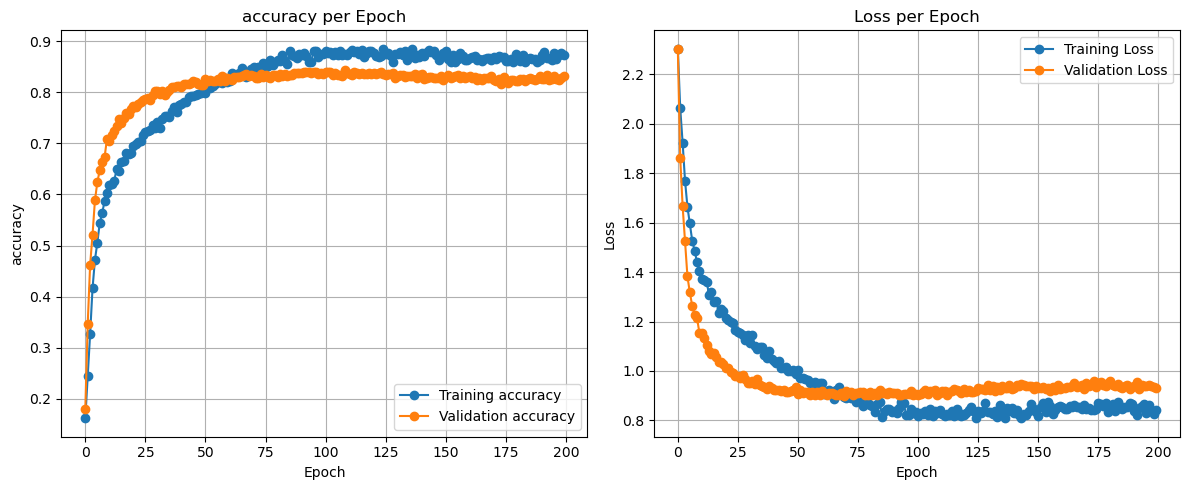

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training accuracy', marker='o')
if 'val_accuracies' in globals(): 
    plt.plot(val_accuracies, label='Validation accuracy', marker='o')
plt.title('accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', marker='o')
if 'val_losses' in globals():
    plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'LR')

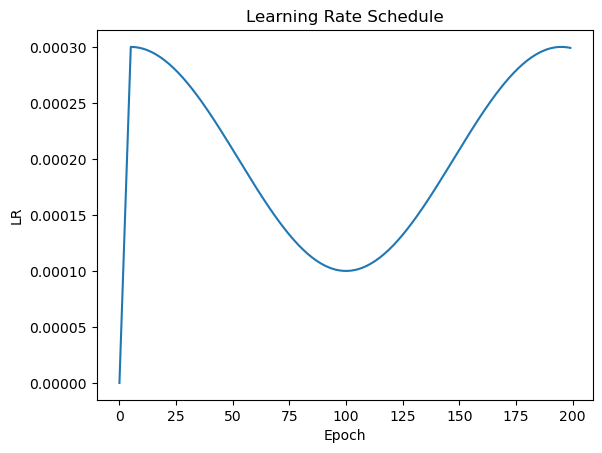

In [14]:
plt.plot(lrs)
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("LR")